
# Training an image classifier on MNIST

The goal of this tutorial is to get you familiar with the training of neural networks.

Training a neural network comes with important decisions to make, regarding various hyperparameters: network architecture, optimizer parameters, cost function, etc. This tutorial explain each of these steps, with practical exercices.


### Supervised classification

Classification is a machine learning task, consisting in learning, from a dataset of examples $($ input $x_i,$ its class $y_i)$, a function associating to any new $x$ the right class. More exactly, given a predefined set of $m$ classes, the task is to estimate, for any input $x$, the probability that $x$ belongs to each of the $m$ classes, i.e., a vector in $(\mathbb{R}^+)^m$ with coefficients summing up to 1.

The function $f$ to estimate is represented as a parametric function $\mathcal{f}_{\theta}$. In machine learning, parameters $\theta$ are _learned_ through a training procedure, in order that the associated function $f_\theta$ solves the task as good as possible. We will explain and tweak together this training procedure.

Simply put, our goal is to produce a program that can output a probability of belonging to a given predetermined class. During this tutorial, our goal is to design a program able to recognize digits from 0 to 9. The different target classes will then be the 10 different digits. 



### MNIST (Mixed National Institute of Standards and Technology)
The MNIST dataset is a collection of hand-written digits images, of size 28x28 pixels.
The dataset is conventionally splitted between a training set of 60000 images and a test set of 10000 images, with no overlap between the two sets. 


Existing datasets provide a common benchmark for all machine learning scientists to compare their results. 
Because of it small size, MNIST is popular both as a safety-check for complex algorithms and to test new ideas. 
It has essentially been solved (this [tech report](http://bulletin.kpi.ua/article/view/84115) displayed a 0.21% error rate, which is superhuman performance). A plethora of datasets exist for various other tasks (object detection, speech-to-text, etc.).

Constituting a dataset is complex, for a lot of different reasons. Collecting, aggregating and annotating the data to obtain a proper database is costly. Indeed, the dataset need to be representative of the input distribution (e.g. diverse and of sufficient size), not have unwanted biases (see for instance [this article](https://www.theverge.com/2019/1/25/18197137/amazon-rekognition-facial-recognition-bias-race-gender) on race bias for face recognition algorithms).
Hence, on the opposite to classical programs, deep algorithms are data-driven - their behaviour will depend on the data they were trained on -, the design of the dataset is as crucial as the design of the algorithm.


### PyTorch
[PyTorch](https://pytorch.org/) is one of the most popular deep learning library right now (the other being [Tensorflow](https://www.tensorflow.org/)). Deep learning libraries provide built-in data types, strong parallelization capacities and a lot of common tools for machine learning research and deployment of machine learning powered algorithms.
We will use Pytorch, whose interface is in Python.


### Outline
----------------------------

1. [Load and normalizing the MNIST training and test datasets using
   ``torchvision``](#scrollTo=8gd658L1MPr4)
2. [Define a Convolution Neural Network](#scrollTo=vaIUMniDLjMR)
3. [Define a loss function](#scrollTo=dIY2c9SFLjMe)
4. [Train the network on the training data](#scrollTo=FatVbfG1LjMw)
5. [Test the network on the test data](#scrollTo=O0YtqZL4LjM3)
6. [Tune parameters and repeat until achieving good results](#scrollTo=vXdO70tzvw4b)

### Conventions
You will meet during the tutorial some  **Parameters sections**. Those are specific places in the code yielding parameters you can tweak to change the training behaviour. 
On some places, the code will be hidden by default, meaning it can either be of low interest (denoted as **Boring code**) or a possible correct answer to a question (denoted as **Possible answer**) that you should check only after having tried to provide an answer by yourself!




## 1. Loading and normalizing MNIST


PyTorch provides an interface with some popular datasets. Splitting between test and train sets and shuffling can be enabled, and various renormalization techniques can be applied to the images.  


In [0]:
import torch
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models

Torchvision.datasets uses the Python Image Library (PIL) to process images. MNIST images are already in the range [0,1].
Most machine learning algorithm work with *Tensors* which are, simply said, multidimensional arrays, with heavily-optimized routines. Most of modern deep learning libraries are optimized to work on Tensors, which are convenient data structures to propagate and to parallelize.


### Parameters section

<a id='param_batch'></a>

* `batch_size`: number of examples that will be looked at for one step of gradient descent. A batch must be representative enough of the original dataset. For instance for MNIST, as there are 10 classes, you might want to consider 10 images picked randomly, one for each class. The subdivision in batches comes from memory limitations: sometimes it is not possible to store all the dataset in memory. Also, it allows to train faster (no need to see the whole dataset to make a first optimization step).
* `transforms`: a list of transformations to be applied on the inputs before feeding them to the network. Common transformations are renormalizations of inputs, and data augmentation (modifying the input in a semantically-neutral way, e.g. translation or rotation of the image, in order to produce other inputs, effectively augmenting the number of samples in the training set). 
A comprehensive list of transforms can be found [here](https://pytorch.org/docs/stable/torchvision/transforms.html).


Try to change the number of images per batch, add normalization and random crops and flips, and see the consequences on training time and accuracy performances.

In [0]:
batch_size=100
transform = transforms.Compose(
    [transforms.ToTensor()])

**Boring code** 

The code below will initialize the dataset with the parameters you inputted, and display an example of a training image. You can execute the cell multiple times to see different images.

Text(0.5, 1.0, 'Ground truth: 5')

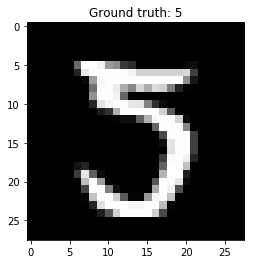

In [0]:
#@title

trainset = torchvision.datasets.MNIST(root='./data/MNIST', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
testset = torchvision.datasets.MNIST(root='./data/MNIST', train=False,
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

classes = ('0', '1', '2', '3',
           '4', '5', '6', '7', '8', '9')

import matplotlib.pyplot as plt
import numpy as np

# display an image from a tensor
def imshow(t):
  a=t.numpy()
  plt.imshow(a,cmap='gray')

def get_random_mnist_img():
  idx=np.random.randint(0,10000)
  data,target=trainset.__getitem__(idx)
  return data,target

img,target = get_random_mnist_img()
img = img.view(28,28)
imshow(img)
plt.title('Ground truth: {}'.format(target))

## 2. Define an architecture


### Build an architecture in PyTorch

A neural network is a feedforward computational graph. Applying it to an input propagates this input forward in the network. From the output obtain, one can compute the _loss_ (or error), which tells how far the network output is from the real answer. To train the network, we need to inform all parameters how they should change in order to decrease this error. This amounts to computing the gradient of the error with respect to the parameters, thanks to a derivative chain rule; this is called _backpropagation_, as this gradient is iteratively backpropagated through all the layers of the network, from the loss towards the input. 

Once the backpropagation has been performed, i.e. that the gradient of the loss function with respect to each parameter is available, the parameters of the network are updated accordingly. Then a new mini-batch of examples is shown, a new update is performed, etc., iteratively. This optimization process is known as _stochastic gradient descent_.
Let $W$ be the network parameters, $J$ the loss function, $\nabla$ the gradient operator, $\mathbf{x}$ the input and $\mathbf{y}$ the ground-truth (i.e. the desired output); parameters are updated iteratively according to the following:  

$W_{t+1} = W_{t} - \eta \nabla_W J(f_{W_t}(\mathbf{x}),\mathbf{y})$.

Most optimizers use a _momentum_ instead of updating directly the weights, in order to smooth the trajectory in the parameter space:

$V_{t+1} = \mu V_{t} + \alpha \nabla_W J(f_{W_t}(\mathbf{x}),\mathbf{y})$

$W_{t+1} = W_t - V_{t+1} $
where $\alpha$ and $\mu$ are hyper-parameters we will deal with later.


Torch handles this mechanism by providing a basic class, `torch.nn.Module`. All instances of that class must implement the `forward` method, that defines the operations successively applied to the input data. Torch provide the  `autograd` package, ensuring automated differentation for tensors with regards to a particular error function. 

Thus, to define your architecture, you only need to describe the forward pass, within the forward function. 

Fill the below code skeleton with differents basics blocks and proceed to the next steps of the tutorial.


### Parameters section

The basic blocks to build the successive layers of a neural network are by PyTorch with the `torch.nn` interface. All the basics you saw in Guillaume's course are here: linear transformations, convolutions, pooling, softmax, non-linearities. We will briefly explain how to use them. The complete list of basic blocks is [here](https://pytorch.org/docs/stable/nn.html).

* `torch.nn.Linear`: compute a linear transformation of the input $x$ (with optional bias). If this basic block's parameters are noted $W$ (and $b$ for the bias), then for an input $X$, this is the linear operation $WX + b$.
  * Parameters: 
    * in_features: size of each input sample (`int`)
    * out_features: size of each output sample (`int`)
    * bias: learns an additional bias (`bool`). Default is `True` 
* `torch.nn.Conv2d`: computes a convolution on the input with the parameterized kernel. Convolutions are much more efficient as first layers on images, since they exploit spatial information and contain much fewer parameters. 
  * Parameters
    * in_channels: number of channels (i.e., of descriptors) of each input sample (`int`). For the first input layer for images,
    it's usually 1 (grayscale) or 3 (RGB).
    * out_channels: number of channels of each output sample (`int`).  
    * kernel_size: size of the kernel window (i.e., the filter) on the image (e.g., $3\times 3$, $5\times 5$, ...). 
    * stride: defines the overlap between two consecutive kernel applications (`int`). Default is 1. Higher stride implies fewer computations, but also lower resolution of the next layer.
    * padding: adds a padding around the input (`int`). Default is 0.
    * bias: learns an additional bias (`bool`). Default is `True`.
* `torch.nn.MaxPool2d`: performs a spatial pooling over the input, by keeping only the maximum value.  Pooling is useful to reduce dimensionality (resolution), but too much of it can lead to lose information.
  * Parameters
    * kernel_size: size of the kernel window (i.e., the pooling mask) on the image. 
    * stride: defines the overlap between two consecutive kernels application (`int`). Default is 1. 
    * padding: adds a padding on the input (`int`). Default is 0.
* `torch.nn.LogSoftmax`: computes the LogSoftmax of the function (LogSoftmax($x_i$)=$log(\frac{exp(x_i)}{\sum_jexp(x_j)})$). Useful for numerical stability and for correctly considering outputs as probabilities. 
* `torch.nn.ReLu`: applies the popular Rectified Linear Unit non-linearity on the input (ReLu($x$)=$max(x,0)$). Applying non-linearities allows the network to model non-linear functions (since a combination of just linear operations remain linear). ReLu is a good candidate since it has nice numerical stability properties.

Apart from ReLu and pooling operations, all these basics blocks have learnable parameters.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    # to store aliases of torch functions - or add your own definitions
    # Basically, this defines possible layers.
    def __init__(self):
        super(Net, self).__init__()
        self.linear = nn.Linear(64,128)
        
    # your code: replace by whatever you want to try
    # Basically, this tells how the different layers above are arranged in a feedforward 
    # computational graph, with possibly other operations (first compute this, then feed 
    # the result to this layer...).
    def forward(self, x):
        x = F.relu(self.linear(x))
        return x

net = Net()

### Possible answer

In [0]:
#@title

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x),2))
        x = F.relu(F.max_pool2d(self.conv2(x),2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net()

### Insight: number of parameters.

The following code snippet prints the number of parameters in your network. 
Parameters are often floating point variables that will be modified during gradient descent: as such they must be stored in memory, and updated regularly. 

Comparison with popular models will also be displayed.

Note that the number of parameters is not the best way to quantify how "complex" a deep neural network is. Indeed, larger networks are easier to train (on the optimization side) than shallow ones. More parameters means the estimator can predict more complex phenomena: the more variables you have, the easier the optimization to an acceptable solution it is (ask Guillaume or I for more info). Of course, a high number of parameters leads to a high memory overhead, but the training behavior is generally better with larger architectures. 


In [0]:
#@title
def num_param(model):
  return(sum(p.numel() for p in model.parameters() if p.requires_grad))
  
print('Your model has {} parameters\n'.format(num_param(net)))

print('AlexNet, who won the 2012 ILSVRC image classification benchmark '\
      'and started the hype around deep learning, has'\
      ' {} parameters.'.format(num_param(models.alexnet())))
print('More than 61 millions floating point numbers.\n')

print('VGG16, its successor, '\
      'has'\
      ' {} parameters.'.format(num_param(models.vgg16())))
print('More than 138 millions floating point numbers.\n')

print('Resnet18, state of the art in image classification, has'\
      ' {} parameters.'.format(num_param(models.resnet18())))
print('More than 11 millions floating point numbers.\n')

Your model has 21840 parameters

AlexNet, who won the 2012 ILSVRC image classification benchmark and started the hype around deep learning, has 61100840 parameters.
More than 61 millions floating point numbers.

VGG16, its successor, has 138357544 parameters.
More than 138 millions floating point numbers.

Resnet18, state of the art in image classification, has 11689512 parameters.
More than 11 millions floating point numbers.



## 3. Define a loss function and pick an optimizer


The loss function is the criterion we will use to quantify how well our network is performing on our problem (image classification). 
Loss function design and/or choice is crucial: it defines what a neural network will (and will not) learn. 

Torch provides several popular loss functions used in the litterature. See the [torch.nn module documentation](https://pytorch.org/docs/stable/nn.html#crossentropyloss) and seek for functions with `Loss`.

The optimizer is the algorithm responsible to perform gradient descent. Several hyperparameters, such as the learning rate, can (and should) be used to tune the algorithm performance.

### Parameters section

Gradient descent: $W$ are the parameters, $\alpha$ the learning rate, $\mu$ the momentum, $J$ is the loss function and $\nabla$ the gradient operator. _t_ is the current timestep. 

$V_{t} = \mu V_{t-1} + \alpha \nabla J (W_t)$

$W_{t+1} = W_t - V_t $

* `criterion`: the loss function to use. One can use one defined in `torch.nn` module or design and implement their own. It is the $J$ function.
* `optimizer`: an implementation of the gradient descent algorithm. Popular choices are `SGD` or `Adam`. You will want to optimize the net parameters, obained with `net.parameters()`. Optimizers are available under the [torch.optim](https://pytorch.org/docs/stable/optim.html) module.
* `learning_rate`: describes how much we move in the direction of the gradient at each optimization step. It is the parameter $\alpha$.
* `momentum`: Quantify the influence of previous gradient calculations. It is the parameter $\mu$.

In [0]:
import torch.optim as optim

learning_rate = 1.
momentum = 0.1
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

### Possible answer

In [0]:
#@title
learning_rate = 0.001
momentum = 0.9
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

## 4. Train the network

The training process consists of the following steps:

1. Loop over the dataset (using the loader utilities defined earlier)
2. Feed the data to the network
3. Collect the output 
4. Compute the loss between outputs and targets
5. Zero all the gradients in the optimizer (to propagate only the gradient for the current backward pass)
6. Backpropagate the loss
7. Perform gradient descent by taking an optimization step (i.e., updating the parameters)

Write your own training routine, or check the possible answer. Keep track of the train and test losses at each optimization step, this is a crucial information to understand the network's behaviour. 


### Parameters section
 
* `epochs`: how many times the full dataset will be fed to the network 

In [0]:
epochs=6

for epoch in range(epochs):
  for batch_index, (data,target) in enumerate(trainloader):
    # do some stuff
    print('I am training my net')

I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training my net
I am training

### Possible answer

In [0]:
#@title

# keep track of losses during training time
train_losses = [] 
test_losses = [] 

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for batch_idx, (data,target) in enumerate(trainloader):
      # zero the parameter gradients
      optimizer.zero_grad()
        
      # forward + backward + optimize
      outputs = net(data)
      loss = criterion(outputs, target)
      running_loss += loss.item()
      loss.backward()
      optimizer.step()

      # print statistics
      if batch_idx % 10000 == 0:    # print every 10000 mini-batches
          print('[%d, %5d] loss: %.3f' %
                (epoch + 1, batch_idx + 1, running_loss))
          running_loss = 0.0
        
      # record train loss
      train_losses.append(loss.item())
      
      # do not compute gradients during this phase
      with torch.no_grad():
        # compute test loss on test data
        for batch_idx, (data,target) in enumerate(testloader):

          # forward and loss computation
          outputs = net(data)
          loss = criterion(outputs, target)
 
          # record test loss
          test_losses.append(loss.item())
          
        
        
print('Finished Training')

[1,     1] loss: 2.294


## 5. Test the network on the test data

Splitting our dataset between train set and test set is required to ensure that the network learned relevant features, by checking its ability to generalize on data it has not seen during training. 

Most of classical datasets provided by Torchvision are already splitted.  


**Boring code**
Displays some images of the test set, as well as the ground truth labels for the ten first images.

In [0]:
#@title
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
plt.imshow(np.transpose(torchvision.utils.make_grid(images).numpy(),(1,2,0)))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

### Parameters section

Write your code to evaluate the accuracy of your network. Accuracy is simply the number of correct predictions divided by the total number of samples.

### Possible answer

In [0]:
#@title
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

## 6. Analyze training and network performances


Monitoring train and test loss gives us some visibility on the training process, and allows us to find out potential bugs in the training procedure, or some bad learning behaviours. 
Typically, if the train loss does not decrease, the network is not learning (optimization issue, or architecture not suitable, etc.). If the train loss decreases, the network is learning; if the test loss equals more or less the train loss, the network is able to generalize. If however the test loss is much higher than the train one, the network is overfitting (learns by heart the examples, but unable to generalize to new samples).


### Insight: loss distribution
Increase the duration of training until you observe a divergence between the train and test losses (cf the [epoch cell](#scrollTo=Xeiy_0-Bkp7e) ).

What could be the cause? 

In [0]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 10))
plt.suptitle('Loss analysis')
ax[0].hist(train_losses,100)
ax[0].hist(test_losses,100)
ax[1].plot(range(len(train_losses)),train_losses)
ax[1].plot(range(len(test_losses)),test_losses)
plt.show()

## Save your model

Save your model by executing the following code snippet (on Google Chrome).
Alternatively, select the "Files" tab on the left panel (reveal it by clicking on the right arrow if it is hidden), then download the file `mnist_model.pth`.
This will be useful for the next tutorial.

In [0]:
from google.colab import files
torch.save(net.state_dict(),'mnist_model.pth')
files.download('mnist_model.pth') 